<a href="https://colab.research.google.com/github/owaisahmad315/Artificial-Intelligence-Basic-Practice/blob/main/Lecture_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification on Fasion Mnist using PyTorch**
1. Loading the data set
2. Preprocessing the dataset
3. Definition of Neural Network
4. Training a Neural Network
5. Testing a Neural Network

#**Loading the pakages**

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


#**Loading and visualize data**

In [3]:
# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5), )])


# Load the data: train and test sets

trainset = datasets.FashionMNIST('-/.pytorch/F_MNIST_data', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('-/.pytorch/F_MNIST_data', download = True, train = False, transform = transform)


# Preparing for validation test
indices = list(range(len(trainset)))
np.random.shuffle(indices)

#  to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])



100%|██████████| 26421880/26421880 [00:00<00:00, 119462476.27it/s]


Extracting -/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to -/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6073437.79it/s]

Extracting -/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to -/.pytorch/F_MNIST_data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 63817421.47it/s]


Extracting -/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to -/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17540436.22it/s]


Extracting -/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to -/.pytorch/F_MNIST_data/FashionMNIST/raw



In [4]:
# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle = True)

In [5]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: -/.pytorch/F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

#**Visualize a Batch of Training Data**

In [6]:
trainloader

#**Visualize the Data**

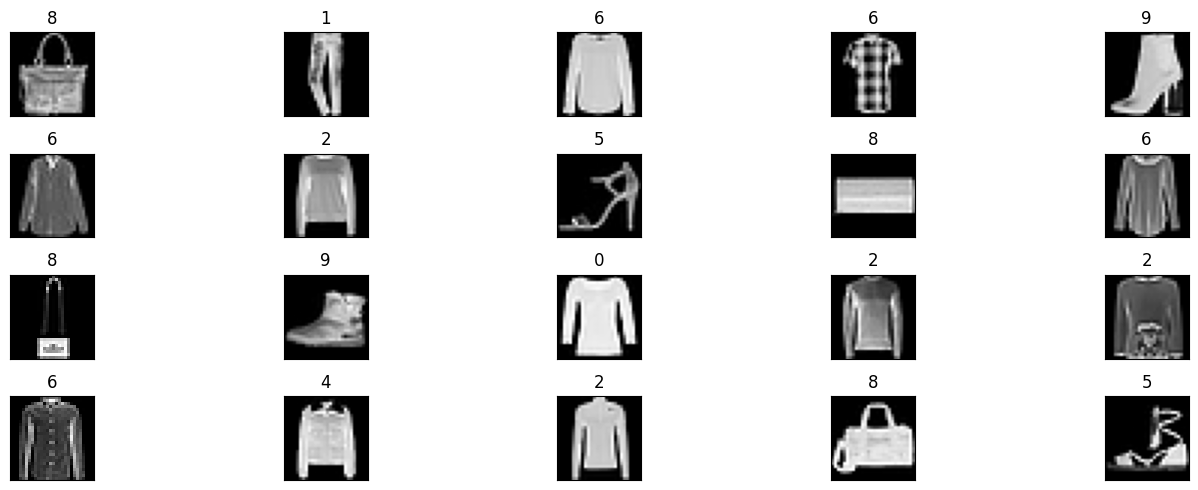

In [7]:
# create an interior for a trainloader
dataiter = iter(trainloader)
print(dataiter)


# get the next batch of data (images and lables)
images, lables = next(dataiter)

# create a figure to display the images
fig = plt.figure(figsize=(15,5))

# Loop through the first 20 images in the batch
for idx in np.arange(20):
  # create a subplot for each image
  ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])

  # display the images using a grayscale colormap
  ax.imshow(np.squeeze(images[idx]), cmap='gray')


  ax.set_title(lables[idx].item())

fig.tight_layout()

#**Define the Neural Network**

In [9]:
# Define a custom classifier class that inherits from nn.Modules

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    # Define the layers of the Neural Network
    self.fcl = nn.Linear(784, 120)
    self.fc2 = nn.Linear(120, 120)
    self.fc3 = nn.Linear(120, 10)
    self.dropout = nn.Dropout(0.2)


  def forward(self, x):
    # reshape the input tensor to have a flat vector shape
    x = x.view(x.shape[0], -1)

    # apply the first fully connected layer with relu activation and dropout
    x = self.dropout(F.relu(self.fc1(x)))

    # apply the second fully connected layer with relu activation and dropout
    x = self.dropout(F.relu(self.fc2(x)))

    # apply the 3rd fully connected layer with relu activation and dropout
    x = F.log_softmax(self.fc3(x), dim = 1)

    return x

#**Training the Model**

In [12]:
model = Classifier()

criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01)

valid_loss_min = np.Inf

epochs = 20

steps = 0

model.train()

train_losses, valid_losses = [], []

for e in range(epochs):
  running_loss = 0
  valid_loss = 0

  # train the model
  for images, labels in trainloader:
    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)

    # validate the model
    for images, lables in validloader:
      log_ps = model(images)
      loss = criterion(log_ps, labels)
      valid_loss += loss.item() * images.size(0)

    # calculate the average loss
    running_loss = running_loss / len(trainloader.sampler)
    valid_loss = valid_loss / len(validloader.sampler)

    train_losses.append(running_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f } \tValidation Loss: {:.6f}'.format(
      e+1,
      running_loss,
      valid_loss
    ))


    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format())
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss